### Prepare master dataframe for vTR activation and repression screens

#### Import packages and define functions

In [3]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/8/2021

import sys
import os
import numpy as np
import matplotlib
# matplotlib.use('pdf') # do this because environment does not have GUI backend
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import re
import statistics
from scipy import stats
import math

# !{sys.executable} -m pip install mpl-axes-aligner
import mpl_axes_aligner

##############################

# define function charge() that calculates the net charge of an amino acid sequence
def charge(AAseq):
    netCharge = 0
    for aa in AAseq:
        if (aa == 'K') or (aa == 'R'):
            netCharge += 1
        elif (aa == 'D') or (aa == 'E'):
            netCharge -= 1
    return netCharge

##############################

# annotate viral family, Baltimore classification, and virus genome based on new information
famDict = {'adenovirus':'Adenoviridae', 'herpesvirus':'Herpesviridae', 'htlv':'Retroviridae', 'papillomavirus':'Papillomaviridae',
           'hepatitis b':'Hepadnaviridae', 'syncytial':'Paramyxoviridae', 'hcv':'Flaviviridae', 'coronavirus':'Coronaviridae',
           'aav':'Parvoviridae', 'polyomavirus':'Polyomaviridae', 'duvenhage':'Rhabdoviridae', 'mokola':'Rhabdoviridae',
           'lyssavirus':'Rhabdoviridae', 'influenza':'Orthomyxoviridae', 'parvovirus':'Parvoviridae', 't-lymphotropic':'Retroviridae',
           'pox':'Poxviridae', 'hiv':'Retroviridae', 'rabies virus':'Rhabdoviridae', 'orf virus':'Poxviridae', 'mumps':'Paramyxoviridae',
           'bunya':'Bunyaviridae', 'pneumovirus':'Pneumoviridae', 'borna':'Bornaviridae', 'lcmv':'Arenaviridae', 'simian virus':'Polyomaviridae',
           'yaba':'Poxviridae', 'retrovirus':'Retroviridae', 'vaccinia':'Poxviridae', 'measles':'Paramyxoviridae', 'rift valley fever':'Bunyaviridae',
           'molluscum':'Poxviridae', 'bovine papular stomatitis':'Poxviridae', 'encephalitis':'Bunyaviridae', 'simian foamy':'Retroviridae',
           'vesicular stomatitis':'Rhabdoviridae', 'hdv':'Deltaviridae'}

BaltDict = {'Adenoviridae':'1', 'Herpesviridae':'1', 'Papillomaviridae':'1', 'Polyomaviridae':'1', 'Poxviridae':'1', 'Anelloviridae':'2',
            'Circoviridae':'2', 'Parvoviridae':'2', 'Picobirnaviridae':'3', 'Reoviridae':'3', 'Astroviridae':'4', 'Caliciviridae':'4',
            'Coronaviridae':'4', 'Flaviviridae':'4', 'Hepeviridae':'4', 'Picornaviridae':'4', 'Togaviridae':'4', 'Arenaviridae':'5',
            'Bornaviridae':'5', 'Bunyaviridae':'5', 'Filoviridae':'5', 'Orthomyxoviridae':'5', 'Paramyxoviridae':'5', 'Pneumoviridae':'5',
            'Rhabdoviridae':'5', 'Retroviridae':'6', 'Hepadnaviridae':'7', 'Deltaviridae':'0'}

genDict = {'1':'DNA', '2':'DNA', '3':'RNA', '4':'RNA', '5':'RNA', '6':'RNA', '7':'DNA', '0':'RNA'}

def prepDF(Rhos, tileInfo, screentype):
    # merge dataframes, sort, and invert scores to be log2(ON:OFF)
    # so, positive = activation and negative = repression
    Rhos = Rhos.rename(columns={'label':'Oligo ID'})
    df = pd.merge(Rhos, tileInfo, how='inner', on='Oligo ID')
    df = df.sort_values(by='Avg')

    if screentype == 'Activation':
        df['R1'] = -1 * df['R1']
        df['R2'] = -1 * df['R2']
        df['Avg'] = -1 * df['Avg']
    elif screentype != 'Repression':
        print('Error: must specify Activation or Repression for screen type')
        return None

    # add tile net charge
    chargeList = [charge(seq) for seq in list(df['Tile Sequence'])]
    df['Net Charge'] = chargeList
    
    # if no virus name, fill with '-' (mostly randomers and fiducials)
    df['Virus'] = df['Virus'].fillna('-')

    # initialize lists for virus family name, Baltimore classification, and genome type
    virFam = []
    virBalt = []
    virGen = []
    # iterate over virus name in dataframe
    for i in list(df['Virus']):
        # default assumption is non-virus
        famName = 'control'
        BaltClass = '-'
        genType = '-'
        # if the 'virus' is not '-', proceed:
        if i != '-':
            # initially set a variable skip to False for each virus name
            skip = False
            # see if famDict key is a substring of the virus name
            for key in famDict:
                # if skip is still false, store the family, class, and genome informtion
                # if skip is true, do not store this information
                if skip == False:
                    if key in i.lower():
                        famName = famDict[key]
                        BaltClass = BaltDict[famName]
                        genType = genDict[BaltClass]
                        # set skip to true once the info has been found/stored
                        skip = True
        
        # add family, class, and genome info to appropriate lists
        # default will be added if these are controls (random, fiducial, non-virus proteins)
        virFam.append(famName)
        virBalt.append(BaltClass)
        virGen.append(genType)
    
    # add the above info to the dataframe
    df['Virus Family'] = virFam
    df['Baltimore Class'] = virBalt
    df['Genome Type'] = virGen

    print('Family, class, and genome type info added')
    return df
    
##############################

def mergeDFs(df, prefixlist, tiledfList):
    df_cols = df.columns
    tiledfs = [pd.read_csv(file) for file in tiledfList]
    # add Oligo ID column
    for i in range(len(tiledfs)):
        tiledfs[i]['Oligo ID'] = prefixList[i] + '_' + tiledfs[i]['Tile ID']
        tiledfs[i] = tiledfs[i].drop(columns=['DNA Sequence', 'Library', 'Type'])

    # identify which columns are shared and which are unique
    tiledf_cols = tiledfs[0].columns

    unique_cols = [col for col in df_cols if col not in set(tiledf_cols)]
    shared_cols = [col for col in df_cols if col in set(tiledf_cols)]

    # merge each dataframe to make a master dataframe
    df['In Original'] = 1

    fulldf = df.copy()
    for i in range(len(tiledfs)):
        fulldf = pd.merge(fulldf, tiledfs[i], how='outer', on=shared_cols)
    print('Dataframes merged')
    fulldf['In Original'] = fulldf['In Original'].fillna(0)

    df['Duplicate'] = 0
    fulldf['Duplicate'] = 0
    
    # remove duplicated entries, which can happen if an immune control is in the sublibrary itself
    df = df.drop_duplicates(subset='Oligo ID', keep='first')
    fulldf = fulldf.drop_duplicates(subset='Oligo ID', keep='first').set_index('Oligo ID')
    print('Preparing to re-add dropouts and non-unique tiles')
    # identify those tiles that don't have an average value (either dropouts or non-unique)
    absent = fulldf[fulldf['Avg'].isnull()]

    for ID in list(absent.index):
        seq = absent.loc[ID, 'Tile Sequence']
        # check if amino acid sequence appeared in screen - if not, these are dropouts
        if seq not in list(df['Tile Sequence']):
            continue
        # fill in missing information for non-unique tiles based on the amino acid sequence
        for col in unique_cols:
            absent.loc[ID, col] = df.loc[df['Tile Sequence'] == seq, col].values[0]
            absent.loc[ID, 'Duplicate'] = 1
    
    absent = absent.reset_index()
    fulldf = fulldf.reset_index()
    
    # concatenate dataframes, sort, and save
    fulldf = pd.concat([df, absent], ignore_index=True)
    fulldf = fulldf.sort_values(by='Avg', ascending=False)

    # filter out things that weren't sequenced (any protein smaller than 60 residues)
    fulldf['Tile End'] = fulldf['Tile End'].fillna(80)
    fulldf = fulldf[fulldf['Tile End'] >= 60]
    print('Information added for all tiles, including non-unique')
    return fulldf

##############################


def filterDF(in_df, library, screentype, sigma, filter_thresh):
    df = in_df.copy()
    print('Filtering dataframe for %s %s screen' % (library, screentype))
    # add ON and OFF counts for each entry (i.e. reads across both fractions)
    df['countsSUM_R1'] = df['countsON_R1'] + df['countsOFF_R1']
    df['countsSUM_R2'] = df['countsON_R2'] + df['countsOFF_R2']
    # create dataframe without duplicated entries for calculation of total reads
    df_nondup = df[df['Duplicate']==0]
    df_nondup = df_nondup.fillna(0)
    
    # calculate total reads per replicate
    sumR1 = sum(list(df_nondup['countsSUM_R1']))
    sumR2 = sum(list(df_nondup['countsSUM_R2'])) 
    
    # remove entries that lack a score in at least one replicate in the original dataframe
    df = df.dropna(subset=['R1', 'R2'])
    df2 = df.copy()
    
    # filter out entries with fewer than 50 reads between both fractions, regardless of sequencing depth
    df = df[(df['countsSUM_R1']>=filter_thresh) & (df['countsSUM_R2']>=filter_thresh)]
    # subset for library of interest
    df = df[df['Oligo ID'].str.contains(library)]
    # compute random control mean and standard deviation for calling hits
    df['Hit'] = 0
    randoms = list(df[(df['Oligo ID'].str.contains('random')) & (df['Oligo ID'].str.contains(library))]['Avg'])
    
    cutoff = statistics.mean(randoms) + sigma*statistics.stdev(randoms)
    df.loc[df.Avg >= cutoff, 'Hit'] = 1
    
    print('Cutoff for hits with %s sigma is %s' % (str(sigma), str(cutoff)))
    df['Screen'] = screentype
    
    # do same for unfiltered dataframe
    df2 = df2[df2['Oligo ID'].str.contains(library)]
    df2['Hit'] = 0
    df2.loc[df2.Avg >= cutoff, 'Hit'] = 1
    df2['Screen'] = screentype
    
    # return filtered and sorted dataframe
    print('Dataframe filtered')
    return df.sort_values(by='Avg', ascending=False), df2, cutoff

##############################

print('Packages imported and functions defined')

Packages imported and functions defined


#### Prepare dataframes with more detailed information and save with and without duplicate tiles

In [4]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/8/2021

# read in rhos file, extra tile info, and mapping file
Rhos_A = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/ActivD2_bothseqs_combo.csv')
Rhos_R = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/ReprD5_bothseqs_combo.csv')
tileInfo = pd.read_csv('../Supplemental Tables - CSV/20201012_CL_Twist_libraries_compiled_FINAL+filtered.csv')
tileInfo['Protein ID'] = tileInfo['Oligo ID'].str.split('_').str[:-1].str.join('_').str.split('_').str[1:].str.join('_')
mapdf = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping.csv')
mapdf = mapdf.rename(columns={'Virus':'Virus Abbreviation'})
tileInfo = pd.merge(tileInfo, mapdf, how='outer', on='Protein ID')
# print(set(list(mapdf['Protein'])))

# specify sub-libraries in screen and input files with all tiles
prefixList = ['vTR', 'CoV']
tiledfList = ['../Supplemental Tables - CSV/vTR-CoV-tiling/vTR_all-tiles_random-01_immune_fiducial_compiled.csv',
              '../Supplemental Tables - CSV/vTR-CoV-tiling/CoV_all-tiles_random-05_immune_fiducial_compiled.csv']

df_A = prepDF(Rhos_A, tileInfo,'Activation')
fulldf_A = mergeDFs(df_A, prefixList, tiledfList)
savename_A = '../Supplemental Tables - CSV/vTR-CoV-tiling/%s_ActivD2_bothseqs_combo_detailed_log2OnOff' % '-'.join(prefixList)
df_A.to_csv(savename_A + '.csv', index=False)
fulldf_A.to_csv(savename_A + '_reAddDups.csv', index=False)
print('%s activation screen data and metadata have been compiled' % '-'.join(prefixList))

df_R = prepDF(Rhos_R, tileInfo, 'Repression')
fulldf_R = mergeDFs(df_R, prefixList, tiledfList)
savename_R = '../Supplemental Tables - CSV/vTR-CoV-tiling/%s_ReprD5_bothseqs_combo_detailed_log2OnOff' % '-'.join(prefixList)
df_R.to_csv(savename_R + '.csv', index=False)
fulldf_R.to_csv(savename_R + '_reAddDups.csv', index=False)
print('%s repression screen data and metadata have been compiled' % '-'.join(prefixList))

Family, class, and genome type info added
Dataframes merged
Preparing to re-add dropouts and non-unique tiles


C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Information added for all tiles, including non-unique
vTR-CoV activation screen data and metadata have been compiled
Family, class, and genome type info added
Dataframes merged
Preparing to re-add dropouts and non-unique tiles


C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Information added for all tiles, including non-unique
vTR-CoV repression screen data and metadata have been compiled


#### Create single master dataframe for the screen that has all tile information

In [6]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/8/2021

# avoid running the above block again and instead import the files created above
dfA = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
dfR = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ReprD5_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
sigma = 2

# print(dfA[dfA['Oligo ID'].str.contains('CoV')])
dfA_vTR, dfA2_vTR, cutoffA_vTR = filterDF(dfA, 'vTR', 'Activation', sigma, 30)
dfA_CoV, dfA2_CoV, cutoffA_CoV = filterDF(dfA, 'CoV', 'Activation', sigma, 30)
dfR_vTR, dfR2_vTR, cutoffR_vTR = filterDF(dfR, 'vTR', 'Repression', sigma, 30)
dfR_CoV, dfR2_CoV, cutoffR_CoV = filterDF(dfR, 'CoV', 'Repression', sigma, 30)

df = pd.concat([dfA_vTR, dfA_CoV, dfR_vTR, dfR_CoV], ignore_index=True)
df2 = pd.concat([dfA2_vTR, dfA2_CoV, dfR2_vTR, dfR2_CoV], ignore_index=True)

inputDir = '../Supplemental Tables - CSV/vTR-CoV-tiling/'
savename = os.path.join(inputDir, 'vTR-CoV_ActivD2-ReprD5_detailed.csv')
df.to_csv(savename, index=False)
df2.to_csv(savename[:-4] + '_no-filter.csv', index=False)

Filtering dataframe for vTR Activation screen
Cutoff for hits with 2 sigma is 3.24704700060297
Dataframe filtered
Filtering dataframe for CoV Activation screen
Cutoff for hits with 2 sigma is 3.245498097076716
Dataframe filtered
Filtering dataframe for vTR Repression screen
Cutoff for hits with 2 sigma is 0.6920252964595188
Dataframe filtered
Filtering dataframe for CoV Repression screen
Cutoff for hits with 2 sigma is 0.528432092954316
Dataframe filtered


### Screen Vizualization - Reproducibility Plots

In [8]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/15/2021

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

##################################################################

def viz_reproducibility(df, library, screentype, cutoff, hits_to_highlight, colors, 
                        figsize, labelpos, savedir, lims=False):
    df = df[(df['Oligo ID'].str.contains(library)) & (df['Screen']==screentype)]
    
    # compute total number of proteins with hits prior to deduplication of tiles
    totalprotvTR = len(set(list(df[~df['Type'].str.contains('control')]['Protein ID'])))
    totalDNAprot = len(set(list(df[(~df['Type'].str.contains('control')) & (df['Genome Type']=='DNA')]['Protein ID'])))
    totalRNAprot = len(set(list(df[(~df['Type'].str.contains('control')) & (df['Genome Type']=='RNA')]['Protein ID'])))
    totalprothit = len(set(list(df[(~df['Type'].str.contains('control')) & (df['Hit']==1)]['Protein ID'])))
    fractDNAprot = round(totalDNAprot/totalprotvTR, 4)

    df = df[df['Duplicate']==0]
    df['Protein ID'] = df['Tile ID'].str.split('|').str.join('_').str.split('_').str[:-1].str.join('_')
    
    ###################################################################

    df['Annotation'] = np.where(df['Protein'].isin(hits_to_highlight), 'Highlight', '')
    df['Annotation'] = np.where((df['Tile Info'].str.lower().str.contains('random', na=False)) | (df['Type'].str.contains('random', na=False)), 'Random control', df['Annotation'])

    totalprotall = len(set(list(df[df['Annotation']!='random']['Protein ID'])))
    print('Stats for %s %s screen' % (library, screentype))
    print('Total proteins (including controls) detected: %d' % totalprotall)
    print('Total proteins (excluding controls) detected: %d' % totalprotvTR)
    print('Total tiles passing filter of %s: %d' % (str(round(cutoff, 3)), len(df)))
    print('Total hits: %d' % (len(df[df['Hit']==1])))
    print('Total proteins encoding at least one hit: %d' % totalprothit)
    print('Total non-hits: %d\n' % (len(df[df['Hit']==0])))
    
    if lims == False:
        lims = (min([min(list(df['R1'])), min(list(df['R2']))]) - 0.5, max([max(list(df['R1'])), max(list(df['R2']))]) + 0.5)

    #################################################################

    savename = os.path.join(savedir, library+'_'+screentype)
    
    if os.path.isdir(inputDir) == False:
        print('Making directory called %s to store files and plots' % fig1Dir)
        os.mkdir(fig1Dir)
        
    pal = sns.set_palette(sns.color_palette(colors))
    greys = ['#BBBBBB', '#777777']
    alpha = 1
    markersize = 8

    highlight = df[(df['Annotation']=='Highlight') & (df['Hit']==1)]
    highlightX = list(highlight['R1'])
    highlightY = list(highlight['R2'])
    highlightInfo = list(highlight['Tile Info'])

    # all tiles
    if screentype == 'Activation':
        score = 'ON:OFF'
        pad = 4
    elif screentype == 'Repression':
        score = 'OFF:ON'
        pad = 2
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='R1', y='R2', data=df[df['Annotation']==''], color=greys[0], alpha=alpha, linewidth=0, s=markersize)
    sns.scatterplot(x='R1', y='R2', data=df[df['Annotation']=='Random control'], color=greys[1], alpha=alpha, linewidth=0, s=markersize)
    sns.scatterplot(x='R1', y='R2', data=highlight, alpha=alpha, linewidth=0, s=markersize, hue='Protein', palette=pal)
    
    legend_elements = [Line2D([0], [0], marker='o', color='#FFFFFF', label=hits_to_highlight[i], markerfacecolor=colors[i], markersize=markersize/2) for i in range(len(hits_to_highlight))]
    legend_elements.extend([Line2D([0], [0], marker='o', color='#FFFFFF', label='Random', markerfacecolor=greys[1], markersize=markersize/2),
                           Line2D([0], [0], marker='o', color='#FFFFFF', label='All tiles', markerfacecolor=greys[0], markersize=markersize/2)])
    ax.legend(handles=legend_elements, loc=4, frameon=False, bbox_to_anchor=(1.02, 0), labelspacing=0.2, handlelength=0, handletextpad=0.5,
              borderpad=0)
    
    x = [cutoff-pad, cutoff+pad]
    y = [cutoff+pad, cutoff-pad]
    plt.plot(x, y, ls='--', color='#444444', lw=1)
#     plt.plot([lims[0]+1, lims[1]-1], [lims[0]+1, lims[1]-1], color='#444444', lw=1)
    plt.xlim(lims)
    plt.ylim(lims)
    
    if figsize[1] <= 2:
        replabel = 'Rep.'
    else:
        replabel = 'Replicate'
    plt.xlabel('%s 1, log$_2$(%s)' % (replabel, score))
    plt.ylabel('%s 2, log$_2$(%s)' % (replabel, score))
    r1 = np.array(list(df[df['Hit']==1]['R1']))
    r2 = np.array(list(df[df['Hit']==1]['R2']))
    r, p = stats.spearmanr(r1, r2)
    
    if screentype == 'Activation':
        plt.text(x=(lims[0] + 1.5), y=(lims[1] - 2.5), s=('n = %s tiles' % format(len(df), ',d')))
        plt.annotate(xy=labelpos, text='Activators', rotation=45)
    elif screentype == 'Repression':
        plt.text(x=(lims[0] + 0.7), y=(lims[1] - 1.1), s=('n = %s tiles' % format(len(df), ',d')))
        plt.annotate(xy=labelpos, text='Repressors', rotation=45)
        plt.xticks(ticks=[-2, 0, 2, 4, 6], labels=[-2, 0, 2, 4, 6])
    plt.tight_layout()
    plt.savefig(savename + '_alltiles_annotated.png', dpi=1200)
    plt.close()
    return lims

print('Function defined')

Function defined


#### Figures 1C & 1D

In [9]:
inputDir = '../Supplemental Tables - CSV/vTR-CoV-tiling/'
detailedIn = os.path.join(inputDir, 'vTR-CoV_ActivD2-ReprD5_detailed.csv')
df = pd.read_csv(detailedIn)
colorsA = ['#F3CE48', '#F1815F', '#DB3982']
limsA_vTR = viz_reproducibility(df, 'vTR', 'Activation', cutoffA_vTR, ['E1A', 'RTA', 'VP16'],
                                colorsA, (2.595, 2.5), (3.5, 6.6), '../Individual Figure Panels/Figure 1')

colorsR = ['#23BEDB', '#B276C2', '#DB3982']
limsR_vTR = viz_reproducibility(df, 'vTR', 'Repression', cutoffR_vTR, ['E1A', 'ICP0', 'LT'],
                                colorsR, (2.53, 2.5), (0,3), '../Individual Figure Panels/Figure 1')

Stats for vTR Activation screen
Total proteins (including controls) detected: 365
Total proteins (excluding controls) detected: 341
Total tiles passing filter of 3.247: 10715
Total hits: 586
Total proteins encoding at least one hit: 173
Total non-hits: 10129

Stats for vTR Repression screen
Total proteins (including controls) detected: 344
Total proteins (excluding controls) detected: 320
Total tiles passing filter of 0.692: 9573
Total hits: 476
Total proteins encoding at least one hit: 110
Total non-hits: 9097



#### Figure S2A & S2B

In [10]:
inputDir = '../Supplemental Tables - CSV/vTR-CoV-tiling/'
detailedIn = os.path.join(inputDir, 'vTR-CoV_ActivD2-ReprD5_detailed.csv')
df = pd.read_csv(detailedIn)
colorsA = ['#70C632']
limsA_CoV = viz_reproducibility(df, 'CoV', 'Activation', cutoffA_vTR, ['Spike'],
                    colorsA, (2.05, 2), (2, 4.6), '../Individual Figure Panels/Figure S2', lims=limsA_vTR)

colorsR = ['#70C632']
limsR_CoV = viz_reproducibility(df, 'CoV', 'Repression', cutoffR_vTR, ['Spike'],
                    colorsR, (2, 2), (0,2.6), '../Individual Figure Panels/Figure S2', lims=limsR_vTR)

Stats for CoV Activation screen
Total proteins (including controls) detected: 233
Total proteins (excluding controls) detected: 238
Total tiles passing filter of 3.247: 6072
Total hits: 449
Total proteins encoding at least one hit: 119
Total non-hits: 5623

Stats for CoV Repression screen
Total proteins (including controls) detected: 222
Total proteins (excluding controls) detected: 227
Total tiles passing filter of 0.692: 4717
Total hits: 170
Total proteins encoding at least one hit: 55
Total non-hits: 4547



### Domain Calling for Visualization as Tiling Plots

In [11]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date updated: 5/10/2022

# NOTE: these functions use a few global variables, including:
# - hits thresholds for activation and repression screens
# - minimum and maximum screen scores for non-controls to set axis limits
# - dictionary that maps UniProt IDs to protein and virus

# make sure to run the above cells to get these global variables

import mpl_axes_aligner

# this function gets domain start and stop coordinates, as well as max tile score
def domainLimits(temp_df):
    span_starts = []
    span_ends = []
    scores = []
    temp_df_hits = temp_df[temp_df['Hit']==1]
    indices = range(0, len(temp_df_hits))
    temp_df_hits.insert(0, 'index', indices)
    temp_df_hits.set_index('index', inplace=True)
    
    if len(temp_df_hits) == 0:
        return span_starts, span_ends, scores
    temp_start = np.nan
    temp_scores = []
    # create range for all tiles excluding the last tile
    for i in range(0, len(temp_df_hits)):
        # if tile is last one
        if i == (len(temp_df_hits) - 1):
            # if temporary start of domain has been defined
            if ~np.isnan(temp_start):
                span_starts.append(temp_start)
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                scores.append(max(temp_scores))
            # if tile is the only tile (first and last)
            elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                scores.append(temp_df_hits.loc[i, 'Avg'])
        # if tile is not last one
        else:
            # if not consecutive
            if (int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) + 1) != (int(temp_df_hits.loc[i+1, 'Tile ID'].split('_')[-1])):
                # if a temporary start of the domain has been defined, then store that start and the end of this tile
                if ~np.isnan(temp_start):
                    span_starts.append(temp_start)
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    scores.append(max(temp_scores))
                    # reset temporary start to nan
                    temp_start = np.nan
                    temp_scores = []
                # if the tile is at the N-terminus, then store the start/stop of the domain
                elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                    span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    scores.append(temp_df_hits.loc[i, 'Avg'])
            # if consecutive
            else:
                # if start of domain is not yet defined
                if np.isnan(temp_start):
                    temp_start = temp_df_hits.loc[i, 'Tile Start']
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                # if tile is in the middle of a domain
                else:
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                    continue
                
    return span_starts, span_ends, scores

###############################
        
# this function makes tiling plots
def plotDomain(gene, temp_df, protDF, domainDict, indivDir_path, save_root):
    # subset for activation
    temp_dfA = temp_df[temp_df['Screen']=='Activation']
    temp_dfA = temp_dfA.drop_duplicates(subset='Tile ID')
    temp_IDsA = list(temp_dfA['Oligo ID'])
    temp_dfA.set_index('Oligo ID', inplace=True)
    
    # get activation points and error
    xA = [(1 + (temp_dfA.loc[ID]['Tile Start'] + temp_dfA.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsA]
    xerrA = [(temp_dfA.loc[ID]['Tile End'] - temp_dfA.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsA]
    yA = [temp_dfA.loc[ID]['Avg'] for ID in temp_IDsA]
    yerrA = list(temp_dfA['Standard Error'])
    
    # get activation domain info
    domain_startsA, domain_endsA, scoresA = domainLimits(temp_dfA)
    print('Activation domain starts/stops/scores:', domain_startsA, domain_endsA, scoresA)

    # subset for repression
    temp_dfR = temp_df[temp_df['Screen']=='Repression']
    temp_dfR = temp_dfR.drop_duplicates(subset='Tile ID')
    temp_IDsR = list(temp_dfR['Oligo ID'])
    temp_dfR.set_index('Oligo ID', inplace=True)
    
    # get repression points and error
    xR = [(1 + (temp_dfR.loc[ID]['Tile Start'] + temp_dfR.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsR]
    xerrR = [(temp_dfR.loc[ID]['Tile End'] - temp_dfR.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsR]
    yR = [temp_dfR.loc[ID]['Avg'] for ID in temp_IDsR]
    yerrR = list(temp_dfR['Standard Error'])
    
    # get repression domain info
    domain_startsR, domain_endsR, scoresR = domainLimits(temp_dfR)
    print('Repression domain starts/stops/scores:', domain_startsR, domain_endsR, scoresR)

    # create axis objects and plot tile centers vs log2(ON:OFF) scores
    fig, ax = plt.subplots(figsize=(2.6,1.5))
    ax2 = ax.twinx()
    colors = ['#23BEDB', '#D7AC00', '#DB3982']
    markersize = 4
    
    # the following stores extended domain and strongest tile info in domainDict
    # it also draws horizontal spans that highlight the strongest tile in each domain
    # activators
    if len(domain_startsA) != 0:
        for s, e, c in zip(domain_startsA, domain_endsA, scoresA):
            domA = temp_dfA[(temp_dfA['Tile Start']>=s) & (temp_dfA['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domA['Avg']))
            max_coords = [domA[domA['Avg']==max_avg]['Tile Start'][0], domA[domA['Avg']==max_avg]['Tile End'][0]]
            max_seq = domA[domA['Avg']==max_avg]['Tile Sequence'][0]
            
            to_append = [gene, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Activation']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#f5dc79', alpha=0.4, lw=0.8, zorder=-200)
    
    # repressors
    if len(domain_startsR) != 0:
        for s, e, c in zip(domain_startsR, domain_endsR, scoresR):
            domR = temp_dfR[(temp_dfR['Tile Start']>=s) & (temp_dfR['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domR['Avg']))
            max_coords = [domR[domR['Avg']==max_avg]['Tile Start'][0], domR[domR['Avg']==max_avg]['Tile End'][0]]
            max_seq = domR[domR['Avg']==max_avg]['Tile Sequence'][0]
            
            to_append = [gene, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Repression']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#bbdaee', alpha=0.4, lw=0.8, zorder=-150)
     
    # plot tiles, with activators on y-axis 1 and repressors on y-axis 2
    ax.scatter(xA, yA, c=colors[1], zorder=-100, s=markersize)
    for xi, yi, exi, eyi in zip(xA, yA, xerrA, yerrA):
        ax.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[1], zorder=-100, lw=0.8)
    
    ax2.scatter(xR, yR, c=colors[0], zorder=-50, s=markersize)
    for xi, yi, exi, eyi in zip(xR, yR, xerrR, yerrR):
        ax2.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[0], zorder=-50, lw=0.8)

    if '|' in gene:
        ax.set_title('\n('.join(gene_uID_list_dict1[gene].split('(')), fontsize=8)
    else:
        ax.set_title(gene_uID_list_dict1[gene], fontsize=8)
    ax.set_xlabel('Position along Protein')
    colorsTitle = ['#01a4c2', '#c29d09']
    ax.set_ylabel('Act. log$_2$(ON:OFF)', color=colorsTitle[1], labelpad=0)
    ax2.set_ylabel('Repr. log$_2$(OFF:ON)', color=colorsTitle[0], rotation=270, labelpad=10)
    ax2.axhspan(ymin=minScoreA - 0.5, ymax=cutoffR_vTR, color='#FFFFFF', alpha=0.6, zorder=-15)
    ax2.axhline(y=cutoffR_vTR, linestyle='--', color='#666666', lw=1, zorder=0)
    ax.set_ylim(minScoreA - 0.5, maxScoreA + 0.5)
    ax2.set_ylim(minScoreR - 0.5, maxScoreR + 0.5)
    mpl_axes_aligner.align.yaxes(ax, cutoffA_vTR, ax2, cutoffR_vTR, 0.5)
    
    plt.tight_layout()
    
    # save figure and close current plot
    fig_path = os.path.join(indivDir_path, gene_uID_list_dict2[gene] + save_root)
    # do this because you cannot save files with '|' in the name
    fig_path = fig_path.replace('|', '-')
    fig.savefig(fig_path, dpi=1200)
    plt.close()
    
    return domainDict

###############################

# this function batch produces tiling plots while simultaneously storing domain info
def extractDomains(df, protDF, lib_fullName, indivDir_path, save_root):
    if 'herpesvirus' not in lib_fullName:
        df = df[df['Type']==lib_fullName]
    else:
        df = df[(df['Library'].str.contains('herpesvirus')) & (~df['Type'].str.contains('control'))]
    
    # get hits and edit to avoid regex characters
    tileHits = list(df[df['Hit'] == 1]['Oligo ID'])
    geneHits = []
    for hit in tileHits:
        if '|' in hit:
            geneHits.append('_'.join(hit.split('_')[1:3]))
        else:
            geneHits.append(hit.split('_')[1])

    geneHits = set(geneHits)
    geneHitsLen = str(len(geneHits))
    
    # find domains and construct data frame with domain info
    domainDict = {'Protein ID':[],
                  'Extended Start':[],
                  'Extended End':[],
                  'Extended Length':[],
                  'Extended Sequence':[],
                  'Max Start':[],
                  'Max End':[],
                  'Max Sequence':[],
                  'Max Score':[],
                  'Effect':[]}
    incr = 0
    for gene in geneHits:
        incr += 1
        # make temporary dataframe for each gene
        # '|' character is read as an 'or' by regex, so don't include when searching
        if '|' in gene:
            genesearch = '.'.join(gene.split('|'))
        else:
            genesearch = gene
        temp_df = df[df['Oligo ID'].str.contains(genesearch)]
        temp_df = temp_df.sort_values(by='Oligo ID')
        
        # make a plot with enrichment scores for each gene containing hit tiles
        print('Protein %s of %s: plotting log2(ON:OFF) for %s' % (str(incr), geneHitsLen, gene))
        domainDict = plotDomain(gene, temp_df, protDF, domainDict, indivDir_path, save_root)

    finalDF = pd.DataFrame(domainDict)
    print('Finished')
    
    return finalDF

print('Domain calling/plotting functions defined')

Domain calling/plotting functions defined


#### Tiling plots featured in Fig. 1E & S1I-N, plus all domains

In [12]:
# the following creates dictionaries to map UniProt ID to protein and virus names
# this is specifically to produce tiling plot titles and save names
uID_to_gene_df = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping.csv')
uID_list = list(uID_to_gene_df['Protein ID'])
uID_to_gene_df['Virus Protein (ProteinID)'] = uID_to_gene_df['Virus'] + ' ' + uID_to_gene_df['Protein'] + ' (' + uID_to_gene_df['Protein ID'] + ')'
uID_to_gene_df['Protein_Virus_ProteinID'] = uID_to_gene_df['Protein'] + '_' + uID_to_gene_df['Virus'] + '_' + uID_to_gene_df['Protein ID']
gene_uID_list1 = list(uID_to_gene_df['Virus Protein (ProteinID)'])
gene_uID_list_dict1 = dict(zip(uID_list, gene_uID_list1))
gene_uID_list2 = list(uID_to_gene_df['Protein_Virus_ProteinID'])
gene_uID_list_dict2 = dict(zip(uID_list, gene_uID_list2))

###############################

df = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2-ReprD5_detailed.csv')
indivDir_path = '../Individual Figure Panels/vTR_indivProteins_allTiles'
save_root = '_tileScores_vTR.png'
vTRprot = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/uniprot_vTR-census_wo-BSL4.csv')
vTRprot = vTRprot[['Entry', 'Representative Sequence']]
vTRprot = vTRprot.set_index('Entry')

if os.path.isdir(indivDir_path) == False:
    print('Making directory called %s to store plots' % indivDir_path)
    os.mkdir(indivDir_path)

# compute minimum and maximum log2(ON:OFF) for plots
minScoreA = limsA_vTR[0]
maxScoreA = limsA_vTR[1]
minScoreR = limsR_vTR[0]
maxScoreR = limsR_vTR[1]

# extract domains and make tiling plots
domDF_vTR = extractDomains(df, vTRprot, 'vTR_census', indivDir_path, save_root)
domDF_vTR = pd.merge(domDF_vTR, uID_to_gene_df, on='Protein ID', how='left')
domDF_vTR = domDF_vTR.drop_duplicates(subset=['Protein ID', 'Max Score', 'Effect'])
domDF_vTR.to_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR_domains.csv', index=False)


Protein 1 of 240: plotting log2(ON:OFF) for Q6Q1R8
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 2 of 240: plotting log2(ON:OFF) for P24437
Activation domain starts/stops/scores: [191.0] [280.0] [4.217527486389736]
Repression domain starts/stops/scores: [] [] []
Protein 3 of 240: plotting log2(ON:OFF) for P12923
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 4 of 240: plotting log2(ON:OFF) for P24440
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 5 of 240: plotting log2(ON:OFF) for Q8V516
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 6 of 240: plotting log2(ON:OFF) for P06930
Activation domain starts/stops/scores: [1.0] [90.0] [9.609460812534504]
Repression domain starts/stops/scores: [1.0] [80.0] [3.06771238845698]
Protein 7 of 240: plotting log2(ON:OFF) for 

Protein 53 of 240: plotting log2(ON:OFF) for C7B7D3
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [11.0] [98.0] [1.5244726280942458]
Protein 54 of 240: plotting log2(ON:OFF) for P03255
Activation domain starts/stops/scores: [1.0, 101.0] [100.0, 220.0] [7.883686973359053, 7.457179391362546]
Repression domain starts/stops/scores: [1.0, 201.0] [90.0, 289.0] [1.5975089714215531, 3.676051773528007]
Protein 55 of 240: plotting log2(ON:OFF) for C7B7D2
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 56 of 240: plotting log2(ON:OFF) for R9UQN1
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 57 of 240: plotting log2(ON:OFF) for P03204
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [441.0] [570.0] [3.17913308188179]
Protein 58 of 240: plotting log2(ON:OFF) for Q69513
Activation domain starts/stops/scores: [

Protein 101 of 240: plotting log2(ON:OFF) for Q98252
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 102 of 240: plotting log2(ON:OFF) for K0FHU3
Activation domain starts/stops/scores: [511.0] [598.0] [4.375168127221185]
Repression domain starts/stops/scores: [] [] []
Protein 103 of 240: plotting log2(ON:OFF) for Q9QSP3
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 104 of 240: plotting log2(ON:OFF) for Q8QMT0
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 105 of 240: plotting log2(ON:OFF) for Q6Q1S0
Activation domain starts/stops/scores: [1.0] [77.0] [3.3102069570652635]
Repression domain starts/stops/scores: [] [] []
Protein 106 of 240: plotting log2(ON:OFF) for Q98267
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 107 of 240: plotting log2(ON:OFF) for P27552
A

Protein 150 of 240: plotting log2(ON:OFF) for P10541
Activation domain starts/stops/scores: [1.0, 91.0] [130.0, 210.0] [9.843498459189345, 9.23669007640492]
Repression domain starts/stops/scores: [11.0, 151.0] [120.0, 249.0] [1.96284349282334, 3.52080678956978]
Protein 151 of 240: plotting log2(ON:OFF) for Q0NPV0
Activation domain starts/stops/scores: [1.0] [80.0] [3.961255215849196]
Repression domain starts/stops/scores: [] [] []
Protein 152 of 240: plotting log2(ON:OFF) for Q9QB93
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 153 of 240: plotting log2(ON:OFF) for C7B7D5
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 154 of 240: plotting log2(ON:OFF) for P0C570
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 155 of 240: plotting log2(ON:OFF) for Q6WB97
Activation domain starts/stops/scores: [] [] []
Repression domain

Protein 199 of 240: plotting log2(ON:OFF) for Q69567
Activation domain starts/stops/scores: [1.0, 321.0] [110.0, 410.0] [10.717213525537137, 3.2507740492312207]
Repression domain starts/stops/scores: [] [] []
Protein 200 of 240: plotting log2(ON:OFF) for P52539
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 201 of 240: plotting log2(ON:OFF) for P52442
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 202 of 240: plotting log2(ON:OFF) for F5HCV3
Activation domain starts/stops/scores: [531.0] [691.0] [10.02146769667391]
Repression domain starts/stops/scores: [241.0, 551.0] [340.0, 670.0] [1.044481506597362, 1.761224138245287]
Protein 203 of 240: plotting log2(ON:OFF) for Q6TVA4
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 204 of 240: plotting log2(ON:OFF) for P19893
Activation domain starts/stops/scores: [1.0] [120.0] [9

#### Tiling plot featured in Fig. S2C, plus all domains

In [13]:
# the following creates dictionaries to map UniProt ID to protein and virus names
# this is specifically to produce tiling plot titles and save names
uID_to_gene_df = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping.csv')
uID_list = list(uID_to_gene_df['Protein ID'])
uID_to_gene_df['Virus Protein (ProteinID)'] = uID_to_gene_df['Virus'] + ' ' + uID_to_gene_df['Protein'] + ' (' + uID_to_gene_df['Protein ID'] + ')'
uID_to_gene_df['Protein_Virus_ProteinID'] = uID_to_gene_df['Protein'] + '_' + uID_to_gene_df['Virus'] + '_' + uID_to_gene_df['Protein ID']
gene_uID_list1 = list(uID_to_gene_df['Virus Protein (ProteinID)'])
gene_uID_list_dict1 = dict(zip(uID_list, gene_uID_list1))
gene_uID_list2 = list(uID_to_gene_df['Protein_Virus_ProteinID'])
gene_uID_list_dict2 = dict(zip(uID_list, gene_uID_list2))

###############################

df = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2-ReprD5_detailed.csv')
indivDir_path = '../Individual Figure Panels/CoV_indivProteins_allTiles'
save_root = '_tileScores_CoV.png'
CoVprot = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/CoV_full-length-proteins_uID_sequence.csv')
CoVprot = CoVprot[['Entry', 'Representative Sequence']]
CoVprot = CoVprot.set_index('Entry')

if os.path.isdir(indivDir_path) == False:
    print('Making directory called %s to store plots' % indivDir_path)
    os.mkdir(indivDir_path)

# compute minimum and maximum log2(ON:OFF) for plots
minScoreA = limsA_CoV[0]
maxScoreA = limsA_CoV[1]
minScoreR = limsR_CoV[0]
maxScoreR = limsR_CoV[1]

# extract domains and make tiling plots
domDF_CoV = extractDomains(df, CoVprot, 'coronavirus', indivDir_path, save_root)
domDF_CoV = pd.merge(domDF_CoV, uID_to_gene_df, on='Protein ID', how='left')
domDF_CoV = domDF_CoV.drop_duplicates(subset=['Protein ID', 'Max Score', 'Effect'])
domDF_CoV.to_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/CoV_domains.csv', index=False)


Protein 1 of 217: plotting log2(ON:OFF) for Q6Q1R8
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 2 of 217: plotting log2(ON:OFF) for P0C6U6|PRO_0000338232
Activation domain starts/stops/scores: [1.0] [80.0] [4.092772418766092]
Repression domain starts/stops/scores: [] [] []
Protein 3 of 217: plotting log2(ON:OFF) for P0C6X4|PRO_0000297793
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 4 of 217: plotting log2(ON:OFF) for P0C6X2|PRO_5000093333
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 5 of 217: plotting log2(ON:OFF) for Q01455
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 6 of 217: plotting log2(ON:OFF) for K9N7C7|PRO_0000422452
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 7 of 217: plotting log2(ON

Protein 49 of 217: plotting log2(ON:OFF) for K9N7C7|PRO_0000422439
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 50 of 217: plotting log2(ON:OFF) for P0C6U3|PRO_0000338204
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [31.0] [137.0] [2.0871366737641783]
Protein 51 of 217: plotting log2(ON:OFF) for P0C6U3|PRO_0000338198
Activation domain starts/stops/scores: [241.0] [330.0] [3.953442098274496]
Repression domain starts/stops/scores: [] [] []
Protein 52 of 217: plotting log2(ON:OFF) for P0C6W2|PRO_0000291345
Activation domain starts/stops/scores: [61.0, 411.0, 461.0] [150.0, 500.0, 550.0] [3.9696528371206847, 3.6422774216816753, 3.5422111910505896]
Repression domain starts/stops/scores: [] [] []
Protein 53 of 217: plotting log2(ON:OFF) for P0C6X2|PRO_5000093344
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 54 of 217: plotting log2(ON:

Protein 95 of 217: plotting log2(ON:OFF) for P0C6X7|PRO_0000037321
Activation domain starts/stops/scores: [241.0] [340.0] [3.665387351190904]
Repression domain starts/stops/scores: [] [] []
Protein 96 of 217: plotting log2(ON:OFF) for P0C6W2|PRO_0000291340
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 97 of 217: plotting log2(ON:OFF) for P0C6W2|PRO_0000291342
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 98 of 217: plotting log2(ON:OFF) for K9N638|PRO_0000422454
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 99 of 217: plotting log2(ON:OFF) for Q6Q1S2
Activation domain starts/stops/scores: [121.0] [220.0] [4.20882198204828]
Repression domain starts/stops/scores: [941.0] [1090.0] [2.95384898196206]
Protein 100 of 217: plotting log2(ON:OFF) for Q5MQC7
Activation domain starts/stops/scores: [] [] []
Repression domain s

Protein 141 of 217: plotting log2(ON:OFF) for P0C6U7|PRO_0000338248
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 142 of 217: plotting log2(ON:OFF) for P0C6U8|PRO_0000338256
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [121.0] [220.0] [1.5523225254823296]
Protein 143 of 217: plotting log2(ON:OFF) for P0C6U2|PRO_0000338184
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [1.0] [80.0] [0.8065787943807834]
Protein 144 of 217: plotting log2(ON:OFF) for K9N5R3
Activation domain starts/stops/scores: [1.0] [80.0] [3.312020654817509]
Repression domain starts/stops/scores: [] [] []
Protein 145 of 217: plotting log2(ON:OFF) for P0C6U5|PRO_0000338219
Activation domain starts/stops/scores: [81.0] [170.0] [3.6330521087933456]
Repression domain starts/stops/scores: [] [] []
Protein 146 of 217: plotting log2(ON:OFF) for P0DTC1|PRO_0000449638
Activation domain start

Protein 185 of 217: plotting log2(ON:OFF) for P0C5B5
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 186 of 217: plotting log2(ON:OFF) for P0C6X4|PRO_0000297798
Activation domain starts/stops/scores: [341.0, 761.0] [430.0, 850.0] [3.245619687287528, 3.343579792275156]
Repression domain starts/stops/scores: [] [] []
Protein 187 of 217: plotting log2(ON:OFF) for P0C6X3|PRO_0000297785
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 188 of 217: plotting log2(ON:OFF) for A0A6B9WGW4
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 189 of 217: plotting log2(ON:OFF) for P0C6X6|PRO_0000283828
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [871.0, 901.0] [960.0, 990.0] [0.5864045004767677, 1.5242726752715914]
Protein 190 of 217: plotting log2(ON:OFF) for K9N638|PRO_0000422459
Activation domai

### Domain-level Analyses - Strip Plots of Domain Scores

#### Strip plot featured in Fig. 1F&G

In [106]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

dsDNA = '#445DAB'
ssDNA = '#05B5D0'
n_ssRNA = '#86B843'
p_ssRNA = '#2C823D'
p_ssRNA_RT = '#BD58B2'

###############################

vfaminfo = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
vfaminfo = vfaminfo[['Protein ID', 'Virus Family', 'Baltimore Class', 'Genome Type']]
vfaminfo.loc[-1] = ['Q76QJ5', 'Poxviridae', '1', 'DNA']
vfaminfo = vfaminfo.drop_duplicates()
dom = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR_domains.csv')
dom = pd.merge(dom, vfaminfo, on='Protein ID', how='left')
dom['Virus']

genDict2 = {'1':'dsDNA', '2':'ssDNA', '3':'dsRNA', '4':'(+)ssRNA', '5':'(-)ssRNA', '6':'(+)ssRNA-RT', '7':'dsDNA-RT', '0':'(-)ssRNA'}
colorDict = {'dsDNA':dsDNA, 'ssDNA':ssDNA, '(+)ssRNA':p_ssRNA, '(-)ssRNA':n_ssRNA, '(+)ssRNA-RT':p_ssRNA_RT}
dom['Genome Type'] = dom['Baltimore Class'].map(genDict2)

def plot_domEffects(df, screentype, lower_lim, savename):
    df = df[df['Effect']==screentype].sort_values(by='Max Score', ascending=False)
    df['Protein Family'] = df['Protein Family'].replace(to_replace='Agnoprotein', value='AGNO')
    df = df[~df['Genome Type'].isnull()]
    famorder = list(df.drop_duplicates(subset=['Genome Type'])['Genome Type'])
    print(famorder)
    pal = sns.color_palette([colorDict[f] for f in famorder])
    print(famorder)
    
    if screentype == 'Activation':
        plt.figure(figsize=(4.89,1.4))
#         plt.figure(figsize=(3.6,1.4))
        labelname = 'Activation\nlog$_2$(ON:OFF)'
        plt.yticks(ticks=[5, 10], labels=[5,10])
    elif screentype == 'Repression':
        plt.figure(figsize=(4.0,1.45))
#         plt.figure(figsize=(3.9,1.45))
        labelname = 'Repression\nlog$_2$(OFF:ON)'
        
    sns.stripplot(data=df, x='Protein Family', y='Max Score', hue='Genome Type', s=2.5, palette=pal)
    plt.xticks(rotation=90)
    lower_y, upper_y = plt.gca().get_ylim()
    plt.ylim(lower_lim, upper_y)
    plt.ylabel(labelname)
    
    if screentype == 'Activation':
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [0, 2, 4, 3, 1] # order of genome types when ranking data from strongest to weakest domain
        plt.legend(handles = [handles[i] for i in order], labels = [labels[i] for i in order],
                   frameon=False, loc='upper left', bbox_to_anchor=(1,1), title='Genome Type',
                   markerscale=0.3, borderpad=0, handletextpad=0)
#         plt.legend(handles = [handles[i] for i in order], labels = [labels[i] for i in order],
#                    frameon=False, loc='lower left', bbox_to_anchor=(0,1), title='Genome Type',
#                    markerscale=0.3, borderpad=0, handletextpad=0, ncol=5)
        plt.xlabel('')
    elif screentype == 'Repression':
        plt.legend([], frameon=False)
        plt.xlabel('Viral Protein Family')
        
    plt.tight_layout()
    plt.savefig(savename, dpi=1200)
    plt.close()
    print('%s complete' % screentype)
    return upper_y

savenameA = '../Individual Figure Panels/Figure 1/vTR_Activation_domains_ranked.png'
upperA_vTR = plot_domEffects(dom, 'Activation', cutoffA_vTR, savenameA)

savenameR = '../Individual Figure Panels/Figure 1/vTR_Repression_domains_ranked.png'
upperR_vTR = plot_domEffects(dom, 'Repression', cutoffR_vTR, savenameR)


['dsDNA', '(+)ssRNA-RT', 'ssDNA', '(-)ssRNA', '(+)ssRNA']
['dsDNA', '(+)ssRNA-RT', 'ssDNA', '(-)ssRNA', '(+)ssRNA']
Activation complete
['dsDNA', '(-)ssRNA', '(+)ssRNA', 'ssDNA', '(+)ssRNA-RT']
['dsDNA', '(-)ssRNA', '(+)ssRNA', 'ssDNA', '(+)ssRNA-RT']
Repression complete


#### Strip plot featured in Fig. 2B, with additional plot for activation

In [114]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

dom = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/CoV_domains.csv')

def plot_domEffects(df, screentype, lower_lim, upper_lim, savename):
    df = df[df['Effect']==screentype].sort_values(by='Max Score', ascending=False)
    
    if screentype == 'Activation':
        plt.figure(figsize=(2.39,1.255))
        labelname = 'Activation\nlog$_2$(ON:OFF)'
        plt.yticks(ticks=[5, 10], labels=[5,10])
    elif screentype == 'Repression':
        plt.figure(figsize=(1.6,1.4))
        labelname = 'Repression\nlog$_2$(OFF:ON)'
        
    sns.stripplot(data=df, x='Protein', y='Max Score', s=2.5, color='#70C632')
    plt.xticks(rotation=90)
    plt.ylim(lower_lim, upper_lim)
    plt.ylabel(labelname)
    
    if screentype == 'Activation':
        plt.xlabel('')
    elif screentype == 'Repression':
        plt.xlabel('Viral Protein Family')
        
    plt.tight_layout()
    plt.savefig(savename, dpi=1200)
    plt.close()
    print('%s complete' % screentype)

savenameA = '../Individual Figure Panels/Figure 2/CoV_Activation_domains_ranked.png'
plot_domEffects(dom, 'Activation', cutoffA_CoV, upperA_vTR, savenameA)

savenameR = '../Individual Figure Panels/Figure 2/CoV_Repression_domains_ranked.png'
plot_domEffects(dom, 'Repression', cutoffR_CoV, upperR_vTR, savenameR)

Activation complete
Repression complete


### Proteins with Effector Domains Stratified by Viral Family

#### Barplot featured in Fig. 1L

       Family  Bifunctional  Repressor  Activator
1      Herpes          41.0       24.0       54.0
12        Pox           5.0        5.0       24.0
0       Adeno           7.0        1.0        8.0
2   Papilloma           6.0        5.0        7.0
4     Polyoma           3.0        2.0        5.0
5       Retro           2.0        0.0        3.0
6       Borna           2.0        2.0        2.0
9   Orthomyxo           2.0        2.0        2.0
10   Paramyxo           2.0        2.0        2.0
3       Parvo           1.0        0.0        1.0
7       Delta           1.0        1.0        1.0
8       Flavi           1.0        1.0        1.0
11     Pneumo           1.0        1.0        1.0
13      Arena           0.0        0.0        1.0
14     Corona           0.0        0.0        1.0


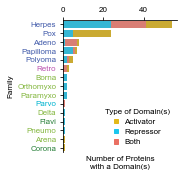

In [112]:
import matplotlib.patches as mpatches

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

vfaminfo = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
vfaminfo = vfaminfo[['Protein ID', 'Virus Family', 'Baltimore Class', 'Genome Type']]
vfaminfo = vfaminfo.drop_duplicates()
dom = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR_domains.csv')
dom = pd.merge(dom, vfaminfo, on='Protein ID', how='left')
dom = dom.rename(columns={'Virus Family':'Family'})

vTRdomAct = dom[dom['Effect']=='Activation']
vTRdomAct = vTRdomAct.drop_duplicates('Protein ID')
vTRA_list = list(vTRdomAct['Protein ID'])

vTRdomRep = dom[dom['Effect']=='Repression']
vTRdomRep = vTRdomRep.drop_duplicates('Protein ID')
vTRR_list = list(vTRdomRep['Protein ID'])

vTRB_list = [b for b in vTRA_list if b in vTRR_list]
vTRA_list = [a for a in vTRA_list if a not in vTRB_list]
vTRR_list = [r for r in vTRR_list if r not in vTRB_list]

vTRdom = pd.concat([vTRdomAct, vTRdomRep])

vTRdom = vTRdom.drop('Virus', axis='columns')
vTRdom['Count'] = 1
vTRB = vTRdom[vTRdom['Protein ID'].str.contains('|'.join(vTRB_list))].drop_duplicates('Protein ID').groupby('Family').sum().reset_index()
vTRA = vTRdom[vTRdom['Protein ID'].str.contains('|'.join(vTRA_list))].drop_duplicates('Protein ID').groupby('Family').sum().reset_index()
vTRR = vTRdom[vTRdom['Protein ID'].str.contains('|'.join(vTRR_list))].drop_duplicates('Protein ID').groupby('Family').sum().reset_index()

vTRfull = vTRB[['Family', 'Count']]
vTRfull = vTRfull.rename(columns={'Count':'Bifunctional'})

for vTRdf, vTRtype in zip([vTRR, vTRA], ['Repressor', 'Activator']):
    vTRdf = vTRdf[['Family', 'Count']]
    vTRdf = vTRdf.rename(columns={'Count':vTRtype})
    vTRfull = pd.merge(vTRfull, vTRdf, on='Family', how='outer')
vTRfull = vTRfull.fillna(0)

vTRfull['Bifunctional'] = vTRfull['Repressor'] + vTRfull['Bifunctional']
vTRfull['Activator'] = vTRfull['Activator'] + vTRfull['Bifunctional']
vTRfull = vTRfull.sort_values(by='Activator', ascending=False)
famList = list(vTRfull['Family'])
vTRfull['Family'] = vTRfull['Family'].str.split('viridae').str[0]
famcolor = [colorDict[genDict2[BaltDict[f]]] for f in famList]
print(vTRfull)

# colors = ['#C3A02E', '#18B4C6', '#EA7063'] # same HEX codes as Illustrator schematics
colors = ['#E3B919', '#1BC6EE', '#EA7063'] # brighter versions

plt.figure(figsize=(2.6,2.5))
sns.barplot(data=vTRfull, x='Activator', y='Family', color=colors[0])
sns.barplot(data=vTRfull, x='Bifunctional', y='Family', color=colors[2])
sns.barplot(data=vTRfull, x='Repressor', y='Family', color=colors[1])
sns.despine(top=False, bottom=True)

A_bar = mpatches.Patch(color=colors[0], label='Activator')
B_bar = mpatches.Patch(color=colors[2], label='Both')
R_bar = mpatches.Patch(color=colors[1], label='Repressor')
plt.legend(handles=[A_bar, R_bar, B_bar], loc='lower right', bbox_to_anchor=(1, 0),
           frameon=False, title='Type of Domain(s)', handlelength=0.5, handleheight=0.5)
plt.xlabel('Number of Proteins\nwith a Domain(s)')

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), famcolor):
    ticklabel.set_color(tickcolor)

plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 1/vTR_domain_virus_distribution_bar.png', dpi=1200)

### MSA Functions and Color Palettes

In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from Bio import AlignIO
# from Bio.Alphabet import IUPAC, Gapped
from Bio.Align import MultipleSeqAlignment as MSA
import math

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

# make dictionary to map ID to MSA sequence
def mapScores(df, align, uniprot_position=0, name_position=2, name=0, domain=False):
    alignDict = {}
    uniprotIDs = []
    virus = []
    sub_starts = []
    sub_ends = []
    for line in align:
        alignDict[line.id] = line.seq
        uniprotIDs.append(line.id.split('|')[uniprot_position])
        if domain == True:
            vir = line.id.split('|')
            vir.remove(line.id.split('|')[uniprot_position])
            vir = '|'.join(vir)
            sub_starts.append(int(line.id.split('|')[-1].split('-')[0]))
            sub_ends.append(int(line.id.split('|')[-1].split('-')[1]))
        elif name == None:
            vir = line.id.split('|')[name_position]
        else:
            vir = line.id.split('|')[name_position].split('_')[name]
        virus.append(vir)
    
    # get length of MSA sequences and map virus name to dataframe
    refLen = len(line.seq)
    refLenRange = range(refLen)
    uniprot_to_virus = dict(zip(uniprotIDs, virus))
    
    # restructure dataframe
    df['Uniprot ID'] = df['Oligo ID'].str.split('_').str[1]
    df = df[df['Uniprot ID'].isin(uniprotIDs)]
    df.loc[:, 'Serotype'] = df['Uniprot ID'].map(uniprot_to_virus)
    df['Tile Start'] = df['Tile Start'] - 1
    if domain == True:
        uniprot_to_substarts = dict(zip(uniprotIDs, sub_starts))
        uniprot_to_subends = dict(zip(uniprotIDs, sub_ends))
        df.loc[:, 'Domain Start'] = df['Uniprot ID'].map(uniprot_to_substarts) - 1
        df.loc[:, 'Domain End'] = df['Uniprot ID'].map(uniprot_to_subends)
    df = df.sort_values(by='Oligo ID')
    
    # establish weights list for 80-aa tiles
    # option 1: equal weights during averaging - this loses even strong effector domains that are not N- or C-terminal
    weights = np.ones(80)
    # option 2: weight scores during averaging so farther tiles contribute less; 1bp-basis causes smoothing - measurements weren't at this resolution
    # weights = [i for i in range(1, 41)]
    # weights = weights + weights[::-1]
    # option 3: weight scores during averaging so farther tiles contribute less; 10bp-basis is more appropriate (resolution of measurements)
#     weights = [int(math.ceil(i/ 10.))*10 for i in range(1, 41)]
#     weights = weights + weights[::-1]
    
    # initialize dictionary to store scores and iterate through each protein in alignment
    scoreDict = {}
    for uID in uniprotIDs:
        # subset data on current protein and store as temporary dataframe
        temp_df = df[df['Uniprot ID']==uID]
        # store pertinent information as lists
        if domain == True:
            temp_df = temp_df[(temp_df['Tile Start']>=temp_df['Domain Start']) & (temp_df['Tile End']<=temp_df['Domain End'])]
            temp_df['Tile Start'] = temp_df['Tile Start'] - temp_df['Domain Start']
            temp_df['Tile End'] = temp_df['Tile End'] - temp_df['Domain Start']
        protLen = max(list(temp_df['Tile End']))
        starts = list(temp_df['Tile Start'])
        ends = list(temp_df['Tile End'])
        scores = list(temp_df['Avg'])
        # initialize arrays to store score and weight info (will update with each tile within a protein)
        totalscore = np.repeat(0, protLen)
        totalweights = np.repeat(0, protLen)
        
        # iterate over tiles, which is equivalent to the length of the scores list
        for s in range(len(scores)):
            # prepare arrays of 0 to add before and after tile information to maintain position information
            prefill = np.repeat(0, int(starts[s]))
            postfill = np.repeat(0, int(protLen - ends[s]))
            # if the tile was not recovered in the screen, set the scores and weights to 0
            if math.isnan(scores[s]): 
                fullscore = np.repeat(0, int(protLen))
                fullweights = np.repeat(0, int(protLen))
            # else if the tile was recovered, then prepare arrays for computing weighted score
            else:
                scorefill = np.repeat(scores[s], 80)
                fullscore = np.concatenate((prefill, scorefill, postfill))
                fullweights = np.concatenate((prefill, weights, postfill))
            
            # multiply score (single value repeated 80 times) by weight (increases as you approach the tile center)
            weightedscore = np.multiply(fullscore, fullweights)
            # increment the current score with the new score and do the same for the weights
            totalscore = np.add(totalscore, weightedscore)
            totalweights = np.add(totalweights, fullweights)
    
        # divide the cumulative weighted score by the cumulative weights
        computedscore = np.divide(totalscore, totalweights)
        # expand these score arrays to match the length of the MSA sequences, adding a nan where there is a dash
        adjustedscore = []
        counter = 0
        for key in alignDict:
            if uID in key:
                for aa in alignDict[key]:
                    if aa != '-':
                        adjustedscore.append(computedscore[counter])
                        counter += 1
                    else:
                        adjustedscore.append(np.nan)
    
        # store virus name as key and adjusted score as value
        scoreDict[uniprot_to_virus[uID]] = adjustedscore

    # convert dictionary to dataframe and transpose for plotting a heatmap in the correct orientation
    df = pd.DataFrame(scoreDict)
    df = df.T
    return df, refLen

def plotMSA(protName, width, height, refLen, step, dfA=None, cutoffA=None, colorA=None, dfR=None, cutoffR=None, colorR=None):
    xrange = range(0, refLen, step)
    if (dfA is None) | (dfR is None):
        fig, (ax_hm, ax_cb) = plt.subplots(1, 2, figsize=(width,height), gridspec_kw={'width_ratios':[97,3]})
        if dfR is None:
            dfA.index = [' '.join([i, protName]) for i in dfA.index]
            sns.heatmap(dfA, mask = dfA.isnull(), cmap=colorA, ax=ax_hm, vmax=10.5, vmin=cutoffA, cbar_ax=ax_cb, cbar_kws={'ticks':[2,4,6,8,10]})
            ax_hm.set_ylabel('Activation') #\n%s Homologs' % protName)
        elif dfA is None:
            dfR.index = [' '.join([i, protName]) for i in dfR.index]
            sns.heatmap(dfR, mask = dfR.isnull(), cmap=colorR, ax=ax_hm, vmax=4.5, vmin=cutoffR, cbar_ax=ax_cb, cbar_kws={'ticks':[1,2,3,4]})
            ax_hm.set_ylabel('Repression') #\n%s Homologs' % protName)
        ax_hm.set_xlabel('Consensus Position')
        ax_hm.set_xticks(xrange)
        ax_hm.set_xticklabels(xrange)
    else:
        dfA.index = [' '.join([i, protName]) for i in dfA.index]
        dfR.index = [' '.join([i, protName]) for i in dfR.index]
        fig, ax = plt.subplots(2, 2, figsize=(width,height), gridspec_kw={'width_ratios':[97,3], 'height_ratios':[1,1]})
        sns.heatmap(dfA, mask = dfA.isnull(), cmap=colorA, ax=ax[0,0], vmax=10.5, vmin=cutoffA, cbar_ax=ax[0,1], cbar_kws={'ticks':[4,6,8,10]})
        sns.heatmap(dfR, mask = dfR.isnull(), cmap=colorR, ax=ax[1,0], vmax=4.5, vmin=cutoffR, cbar_ax=ax[1,1], cbar_kws={'ticks':[1,2,3,4]})
        ax[1,0].set_xlabel('Consensus Position')
        ax[0,0].set_ylabel('Activation') #\n%s Homologs' % protName)
        ax[1,0].set_ylabel('Repression') #\n%s Homologs' % protName)
        ax[0,0].set_xticks(xrange)
        ax[1,0].set_xticks(xrange)
        ax[1,0].set_xticklabels(xrange)
    
    plt.tight_layout()
    return plt

# The following three scripts are from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

saveDir = 'MSA_Files_Figs/'
print('Packages imported')

Packages imported


#### MSA heatmap featured in Fig. 1H

<ipython-input-116-8e50962ff5fe>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tile Start'] = df['Tile Start'] - 1


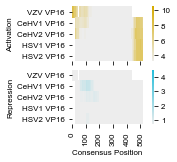

In [118]:
# HHV VP16
align = AlignIO.read('../Alignment Files/VP16_homologs_alignment_file.aln', 'clustal')
dfA = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
dfR = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ReprD5_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')

width = 2.5
height = 2.3
step = 100
savename = '../Individual Figure Panels/Figure 1/VP16_MSA_visualization.png'
dfA, refLen = mapScores(dfA, align)
dfR, refLen = mapScores(dfR, align)
colorA = get_continuous_cmap(['#EEEEEE', '#D7AC00'])
colorR = get_continuous_cmap(['#EEEEEE', '#23BEDB'])
MSA = plotMSA('VP16', width, height, refLen, step, dfA, cutoffA_vTR, colorA, dfR, cutoffR_vTR, colorR)

MSA.savefig(savename, dpi=300)

#### MSA heatmap featured in Fig. 1I

<ipython-input-116-8e50962ff5fe>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tile Start'] = df['Tile Start'] - 1


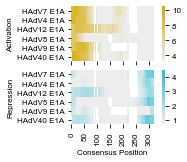

In [119]:
# HAdV E1A
align = AlignIO.read('../Alignment Files/E1A_homologs_alignment_file.aln', 'clustal')
dfA = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
dfR = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ReprD5_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')

width = 2.65
height = 2.3
step = 50
savename = '../Individual Figure Panels/Figure 1/E1A_MSA_visualization.png'
dfA, refLen = mapScores(dfA, align)
dfR, refLen = mapScores(dfR, align)
colorA = get_continuous_cmap(['#EEEEEE', '#D7AC00'])
colorR = get_continuous_cmap(['#EEEEEE', '#23BEDB'])
MSA = plotMSA('E1A', width, height, refLen, step, dfA, cutoffA_vTR, colorA, dfR, cutoffR_vTR, colorR)

MSA.savefig(savename, dpi=300)

#### MSA heatmap featured in Fig. 2C

<ipython-input-116-8e50962ff5fe>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tile Start'] = df['Tile Start'] - 1
<ipython-input-116-8e50962ff5fe>:105: RuntimeWarning: invalid value encountered in true_divide
  computedscore = np.divide(totalscore, totalweights)


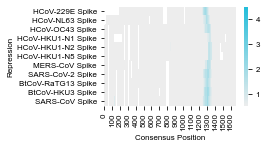

In [120]:
# CoV Spike
align = AlignIO.read('../Alignment Files/spike_homologs_alignment_file.aln', 'clustal')
dfA = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
dfR = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ReprD5_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')

width = 3.75
height = 2.1
step = 100
savename = '../Individual Figure Panels/Figure 2/Spike_MSA_visualization.png'
dfA, refLen = mapScores(dfA, align)
dfR, refLen = mapScores(dfR, align)
colorA = get_continuous_cmap(['#EEEEEE', '#D7AC00'])
colorR = get_continuous_cmap(['#EEEEEE', '#23BEDB'])
MSA = plotMSA('Spike', width, height, refLen, step, dfR=dfR, cutoffR=cutoffR_CoV, colorR=colorR)

MSA.savefig(savename, dpi=1200)

### E1A Perturbation Vignette - original Jupyter notebook in 20211200_E1A_Vignette folder

#### Barplot featured in Fig. 1K

In [123]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/E1A_vignette_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
aggdf = df.groupby(by=['Reporter', 'Condition', 'Construct', 'Protein', 'Replicate', 'Time'], as_index=False).mean()
aggdf['Citrine OFF'] = 1 - aggdf['Citrine']

normdf = aggdf[(aggdf['Condition']=='dox') & (aggdf['Time']>0)]
normdf['Norm Citrine OFF'] = list(np.divide(np.subtract(list(aggdf.loc[(aggdf['Condition']=='dox') & (aggdf['Time']>0)]['Citrine OFF']),
                                                        list(aggdf.loc[(aggdf['Condition']=='nodox') & (aggdf['Time']>0)]['Citrine OFF'])),
                                            list(aggdf.loc[(aggdf['Condition']=='nodox') & (aggdf['Time']>0)]['Citrine'])))
normdf['Norm Citrine OFF'] = normdf['Norm Citrine OFF']*100
# normdf
print('Single-cell flow dataframe loaded')

Single-cell flow dataframe loaded


<ipython-input-123-76832596439f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Norm Citrine OFF'] = list(np.divide(np.subtract(list(aggdf.loc[(aggdf['Condition']=='dox') & (aggdf['Time']>0)]['Citrine OFF']),
<ipython-input-123-76832596439f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Norm Citrine OFF'] = normdf['Norm Citrine OFF']*100


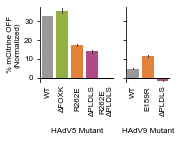

In [124]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

normdf2 = normdf[normdf['Time']==5]
normdf2 = normdf2.replace(to_replace='del', value='\u0394', regex=True)
normdf2['Mutant'] = normdf2['Protein'].str.split(' ').str[1:].str.join(' ')
normdf2 = normdf2.replace(to_replace='E \u0394', value='E\n\u0394', regex=True)
normdf2 = normdf2.replace(to_replace='FOXK1', value='FOXK', regex=True)
normdf2['Construct'] = pd.Categorical(normdf2['Construct'],
                                      ['CL340', 'CL344', 'CL342', 'CL341', 'CL343', 'CL345', 'CL347', 'CL346'])
normdf2 = normdf2.sort_values(by='Construct')

fig, ax = plt.subplots(1, 2, figsize=(2.5,2), gridspec_kw={'width_ratios':[5,3]})
pal5 = sns.color_palette(['#999999', '#9AC42D', '#ff7c1f', '#c4378a', '#DDDDDD'])
pal9 = sns.color_palette(['#999999', '#ff7c1f', '#c4378a'])
sns.barplot(data=normdf2[normdf2['Protein'].str.contains('HAdV5')], x='Mutant', y='Norm Citrine OFF', ax=ax[0], palette=pal5, errwidth=1)
sns.barplot(data=normdf2[normdf2['Protein'].str.contains('HAdV9')], x='Mutant', y='Norm Citrine OFF', ax=ax[1], palette=pal9, errwidth=1)
ax[0].axhline(y=0, color='k', linewidth=1)
ax[0].xaxis.set_tick_params(length=0)
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=90)
# ax[0].set_ylim(-0.025, 0.375)
ax[0].set_ylim(-2.5, 37.5)
ax[0].set_xlabel('\nHAdV5 Mutant')
ax[0].set_ylabel('% mCitrine OFF\n(Normalized)')
sns.despine(bottom=True, ax=ax[0])

ax[1].axhline(y=0, color='k', linewidth=1)
ax[1].xaxis.set_tick_params(length=0)
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=90)
# ax[1].set_ylim(-0.025, 0.375)
ax[1].set_ylim(-2.5, 37.5)
ax[1].set_xlabel('\nHAdV9 Mutant')
ax[1].set_ylabel('')
ax[1].set_yticklabels(labels=[])
sns.despine(bottom=True, ax=ax[1])
plt.tight_layout()

plt.savefig('../Individual Figure Panels/Figure 1/E1A_CR4_vignette_day-5_barplot_norm-cit-OFF.png', dpi=1200)